In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
Organoid_Names = ['697_1_MAP2.xls',
                  '697_2_MAP2.xls', 
                  '697_3_MAP2.xls',
                  '697_4_MAP2.xls',
                  'BCELL_1_MAP2.xls',
                  'BCELL_2_MAP2.xls', 
                  'BCELL_3_MAP2.xls',
                  'BCELL_4_MAP2.xls']

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
Entity_Names = ['697_1_CFSE.xls',
                '697_2_CFSE.xls', 
                '697_3_CFSE.xls',
                '697_4_CFSE.xls',
                'BCELL_1_CFSE.xls',
                'BCELL_2_CFSE.xls', 
                'BCELL_3_CFSE.xls',
                'BCELL_4_CFSE.xls']

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 27203 / 24034
[Open3D DEBUG] #   Got kernel density: 0.00585699 (s), 356.043 (MB) / 356.043 (MB) / 356 (MB)
[Open3D DEBUG] #     Got normal field: 0.0775981 (s), 361.0 (MB) / 361.0 (MB) / 361 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.600071e-06 / 4.352672e-02
[Open3D DEBUG] #       Finalized tree: 0.047786 (s), 369.934 (MB) / 369.934 (MB) / 369 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0641239 (s), 370.051 (MB) / 370.051 (MB) / 370 (MB)
[Open3D DEBUG] #Set point constraints: 0.0115771 (s), 370.738 (MB) / 370.738 (MB) / 370 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 288149 / 325416 / 3897
[Open3D DEBUG] Memory Usage: 370.738 MB
[Open3D DEBUG] # Linear system solved: 0.382173 (s), 382.449 (MB) / 382.449 (MB) / 382 (MB)
[Open3D DEBUG] Got average: 0.00662994 (s), 382.691 (MB) / 382.691 (MB) / 382 (MB)
[Open3D DEBUG] Iso-Value: 5.085182e-01 = 1.383322e+04 / 2.720300e+04
[Open3D DEBUG] #          Total Solve:       1.8 

 / Solved in:  0.002 /  0.017 /  0.071	(418.020 MB)	Nodes: 35937
          GS: 1.7195e-01 -> 1.7195e-01 -> 1.8390e-03 (1.1e-02) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.002 /  0.002	(418.020 MB)	Nodes: 2656
            GS: 1.3693e-01 -> 1.3693e-01 -> 5.9451e-04 (4.3e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.003	(418.020 MB)	Nodes: 4056
              GS: 9.5009e-02 -> 9.5009e-02 -> 4.0269e-04 (4.2e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.011	(418.020 MB)	Nodes: 6552
                GS: 5.5754e-02 -> 5.5754e-02 -> 1.5987e-04 (2.9e-03) [8]
Cycle[0] Depth[ 9/10]:	Updated constraints / Got system / Solved in:  0.003 /  0.004 /  0.005	(418.020 MB)	Nodes: 4376
                  GS: 2.2012e-02 -> 2.2012e-02 -> 4.1096e-05 (1.9e-03) [8]
Cycle[0] Depth[10/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.003 /  0.006	(418.020 M

[Open3D DEBUG] # Linear system solved: 0.336687 (s), 580.945 (MB) / 586.199 (MB) / 586 (MB)
[Open3D DEBUG] Got average: 0.00834799 (s), 580.945 (MB) / 586.199 (MB) / 586 (MB)
[Open3D DEBUG] Iso-Value: 5.058904e-01 = 1.614246e+04 / 3.190900e+04
[Open3D DEBUG] #          Total Solve:       1.6 (s),     588.7 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'
[Open3D DEBUG] Input Points / Samples: 1595 / 1183
[Open3D DEBUG] #   Got kernel density: 0.00181794 (s), 588.672 (MB) / 588.672 (MB) / 588 (MB)
[Open3D DEBUG] #     Got normal field: 0.00947213 (s), 588.672 (MB) / 588.672 (MB) / 588 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 1.146270e-05 / 1.828300e-02
[Open3D DEBUG] #       Finalized tree: 0.0307181 (s), 588.672 (MB) / 588.672 (MB) / 588 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.077661 (s), 588.672 (MB) / 588.672 (MB) / 588 (MB)
[Open3D DEBUG] #Set point constraints: 0.00811505 (s), 588.672 (MB) / 588.672 (MB) / 588 (MB)
[Open3D 

Cycle[0] Depth[ 4/10]:	Updated constraints / Got system[Open3D DEBUG] #          Total Solve:       1.2 (s),     604.8 (MB) / Solved in:  0.002 /  0.006 /  0.003	(572.848 MB)	Nodes: 4913
        GS: 1.8891e-01 -> 1.8891e-01 -> 2.8694e-03 (1.5e-02) [8]
Cycle[0] Depth[ 5/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.018 /  0.091	(572.848 MB)	Nodes: 35937
          GS: 1.7017e-01 -> 1.7017e-01 -> 1.6673e-03 (9.8e-03) [8]
Cycle[0] Depth[ 6/10]:	Updated constraints / Got system / Solved in:  0.001 /  0.003 /  0.002	(572.848 MB)	Nodes: 2552
            GS: 1.2464e-01 -> 1.2464e-01 -> 7.5475e-04 (6.1e-03) [8]
Cycle[0] Depth[ 7/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.002 /  0.002	(572.848 MB)	Nodes: 4088
              GS: 9.6109e-02 -> 9.6109e-02 -> 4.9559e-04 (5.2e-03) [8]
Cycle[0] Depth[ 8/10]:	Updated constraints / Got system / Solved in:  0.002 /  0.004 /  0.016	(572.848 MB)	Nodes: 7376
                GS: 5.7652e-02 -> 5.7652e-02 -> 9.2917e-04 (1.6e

[Open3D DEBUG] # Linear system solved: 0.218186 (s), 619.199 (MB) / 619.199 (MB) / 619 (MB)
[Open3D DEBUG] Got average: 0.00482607 (s), 619.199 (MB) / 619.199 (MB) / 619 (MB)
[Open3D DEBUG] Iso-Value: 5.160819e-01 = 6.657456e+02 / 1.290000e+03
[Open3D DEBUG] #          Total Solve:       1.4 (s),     619.2 (MB)
[Open3D WARNING] Ignoring attribute 'normals' for TensorMap with primary key 'indices'


In [5]:
dict_keys = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

d = dict(zip(dict_keys, distances))

In [6]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
display(df)

Entity  Distance to Surface (μm)
0          A                  2.796946
1          A                  1.268108
2          A                  0.730622
3          A                  1.243128
4          A                  1.001198
...      ...                       ...
12755      H                       NaN
12756      H                       NaN
12757      H                       NaN
12758      H                       NaN
12759      H                       NaN

[12760 rows x 2 columns]

In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'D', 'Types'] = 'Repeat 4'  
df.loc[df['Entity'] == 'E', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'F', 'Types'] = 'Repeat 2'
df.loc[df['Entity'] == 'G', 'Types'] = 'Repeat 3'  
df.loc[df['Entity'] == 'H', 'Types'] = 'Repeat 4'

df['Entity'] = df['Entity'].replace({
              'A':'697',
              'B':'697',
              'C':'697',
              'D':'697',
              'E':'BLymphocyte',
              'F':'BLymphocyte',
              'G':'BLymphocyte',
              'H':'BLymphocyte'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]
display(df_final)

#df_filtered below filters for measurements above 10μm
df_filtered = df_final[df_final['Distance to Surface (μm)'] > 10]
df_filtered.to_excel("df_filtered.xlsx", sheet_name='filtered')

#Below are lines of code to extract the number of values for each 'Entity' given as "count of values for each entity"
entity_counts = df_filtered['Entity'].value_counts()

# Print the results
print("Count of values for each entity:")
print(entity_counts)

# Group by 'Entity' and 'Types' and calculate the count for each group
entity_type_counts = df_filtered.groupby(['Entity', 'Types']).size().reset_index(name='Count')

# Print the results
print("Count of values for each entity and replicate:")
print(entity_type_counts)

Entity  Distance to Surface (μm)     Types
0              697                  2.796946  Repeat 1
1              697                  1.268108  Repeat 1
2              697                  0.730622  Repeat 1
3              697                  1.243128  Repeat 1
4              697                  1.001198  Repeat 1
...            ...                       ...       ...
12450  BLymphocyte                  3.359197  Repeat 4
12451  BLymphocyte                  2.447043  Repeat 4
12452  BLymphocyte                  3.914990  Repeat 4
12453  BLymphocyte                  2.029639  Repeat 4
12454  BLymphocyte                 74.060898  Repeat 4

[8893 rows x 3 columns]

Count of values for each entity:
697            396
BLymphocyte    279
Name: Entity, dtype: int64
Count of values for each entity and replicate:
        Entity     Types  Count
0          697  Repeat 1     76
1          697  Repeat 2    192
2          697  Repeat 3     60
3          697  Repeat 4     68
4  BLymphocyte  Repeat 1     44
5  BLymphocyte  Repeat 2    102
6  BLymphocyte  Repeat 3     70
7  BLymphocyte  Repeat 4     63


In [8]:
#leukemia data
df.rename(columns={'A': 'Leukemia Replicate 1',
                   'B': 'Leukemia Replicate 2',
                   'C': 'Leukemia Replicate 3',
                   'D': 'Leukemia Replicate 3',
                   'E': 'B Lymphocyte Replicate 1',
                   'F': 'B Lymphocyte Replicate 2',
                   'G': 'B Lymphocyte Replicate 3',
                   'H': 'B Lymphocyte Replicate 4'}, inplace=True)

#df.to_excel("unmelted_leukemiabcell_data.xlsx", sheet_name='unmeltedLEUK') 
df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")
df_leukemia.to_excel("melted_leukemiabcell_data.xlsx", sheet_name='meltedLEUK') 

/var/folders/9w/4xkqf_xd0kg5ycr900ldx_9w0000gn/T/ipykernel_8844/188463332.py:12: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df_leukemia = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")


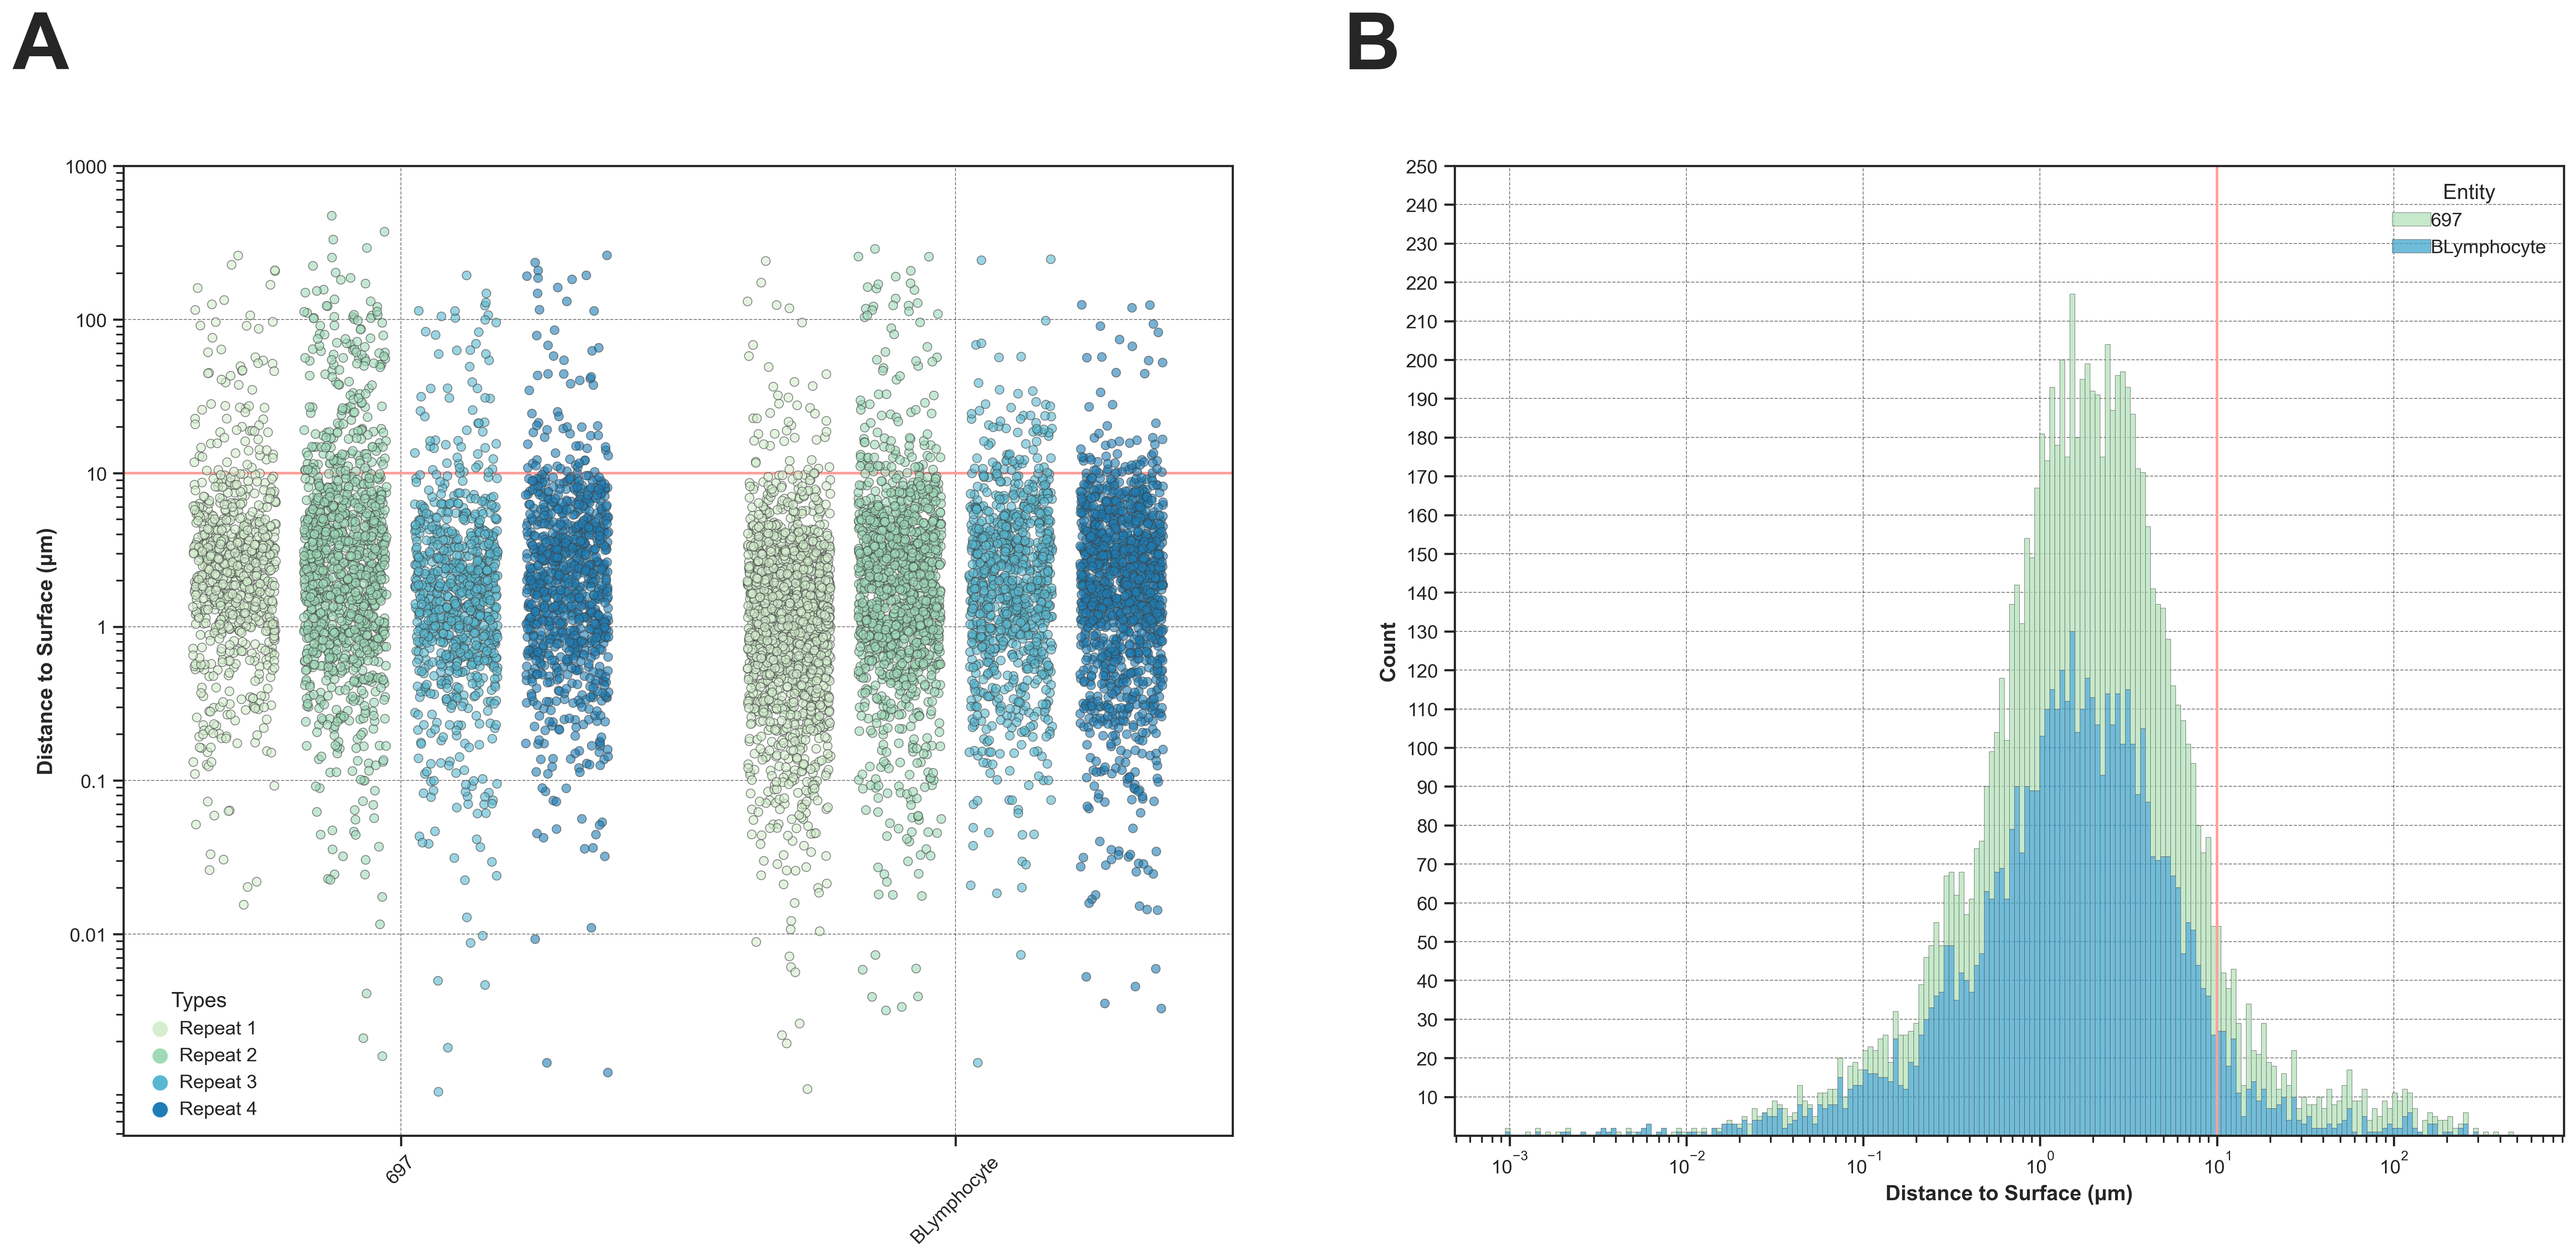

In [9]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': [2, 2]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
    
g.set_yscale("log")
# the non-logarithmic labels
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Entity', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

g.axvline(x=10, color='r')

texts = ['A', 'B']
ax = fig.get_axes()
for a,l in zip(ax, texts):
    a.annotate(l, xy=(-0.1, 1.1), xycoords="axes fraction", fontsize=45, weight = 'bold')

plt.savefig(plot_savepath('Seaborn_697_v BCell.pdf'), bbox_inches='tight')
plt.savefig(plot_savepath('Seaborn_697_v BCell.png'), dpi=300, bbox_inches='tight')

plt.show()

In [10]:
#vis = o3d.visualization.Visualizer()
#vis.create_window(visible=False) #works for me with False, on some systems needs to be true
#vis.add_geometry(final_mesh_org)
#vis.update_geometry(final_mesh_org)
#vis.poll_events()
#vis.update_renderer()
#vis.capture_screen_image(plot_savepath('1857.png'), do_render=True)
#vis.destroy_window()